# 4. Mushroom foraging

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import mglearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, make_scorer


pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv',delimiter=';')

X = df.drop('class', axis=1)
y = df['class']
print((df.isna().sum()/len(df)) * 100)
df.drop(['gill-spacing', 'stem-root', 'veil-type', 'veil-color', 'stem-surface', 'spore-print-color'], inplace=True, axis=1)
df.dropna(inplace=True)

categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = ohe.fit_transform(X_train[categorical_features])
X_test_encoded = ohe.transform(X_test[categorical_features])
    
scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

X_train = np.concatenate((X_train_encoded, X_train_numerical), axis=1)
X_test = np.concatenate((X_test_encoded, X_test_numerical), axis=1)



class                    0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-type               94.797688
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


For data preparation we first take a look at the data, where and the entries that have a lot of missing rows like: stem-root, spore-print-color...

We can't have those when we do the `dropna` which drops all rows including any missing values, if we do then we will end up dropping a big portion of the dataset.

After cleaning is done we have to handle string label values, which in this case we do by doing one-hot encoding, meaning we add an additional column for each unique value of the feature (either 0 or 1) which indicates if that is the value for that feature on that row. All of that is done for us by the `OneHotEncoder`.

Finally we are scaling all the numerical values using the `StandardScaler` and concatenating together with the encoded data.

In [7]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Elastic Net mixing parameter
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scorer = make_scorer(accuracy_score)

lr = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    tol=0.01,
    random_state=42,
    max_iter=1000
)

grid_search = GridSearchCV(
    lr,
    param_grid,
    scoring=accuracy_scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)


lr = grid_search.best_estimator_
y_pred = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)


Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'C': 1, 'l1_ratio': 0.75}
Best accuracy score: 0.8662777607204994
Test accuracy: 0.8645816276404127


In this cell we do cross validation based on which we adjust the `C` and `l1_ratio` parameters on the `LogisticRegression`. We do that by using the `GridSearchCV` class from `sklearn`, which automatically performs cross validation on the given model with a certain param grid.

In this case here we optimize for accuracy, which usully leads to the best "all around" model, but as we will see later it might not be the best for the real world scenario we are in.

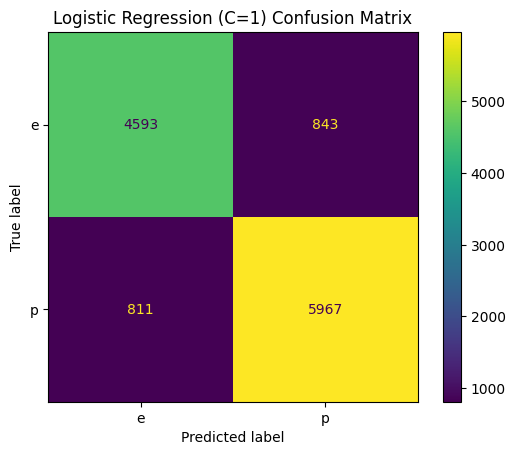

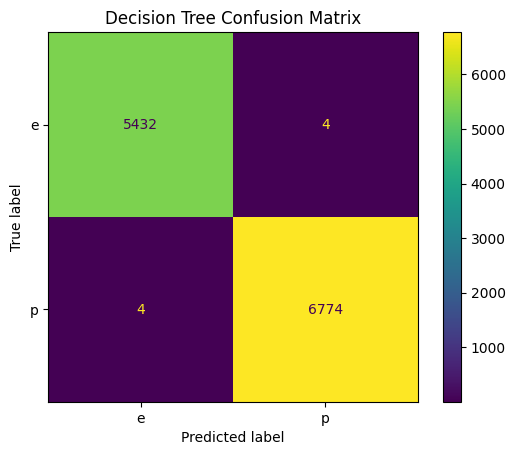

In [4]:
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['e', 'p'])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['e', 'p'])
disp_lr.plot()
plt.title(f"Logistic Regression (C=1) Confusion Matrix")
plt.show()


dtr = DecisionTreeClassifier(max_depth=100, random_state=42)
dtr.fit(X_train, y_train)

y_pred_tree = dtr.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=['e', 'p'])
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['e', 'p'])
disp_tree.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

As we can see on the confusion matrix the `DecisionTreeClassifier` does quite a bit better than the `LogisticRegression` model. We can see 4 false edible predictions and 4 false poisionous prediction. Whereas on the `LogisticRegression` we have 948 false edible and 660 false poisonous predictions.

In [19]:
def calculate_metrics(y_true, y_pred, labels=['e', 'p']):
    precision = precision_score(y_true, y_pred, pos_label='p')
    recall = recall_score(y_true, y_pred, pos_label='p')
    f1 = f1_score(y_true, y_pred, pos_label='p')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy
precision_tree, recall_tree, f1_tree, accuracy_tree = calculate_metrics(
    y_test, y_pred_tree
)
precision_lr, recall_lr, f1_lr, accuracy_lr = calculate_metrics(
    y_test, y_pred_lr
)

data = {
    'Model': [
        'Logistic Regression (CV)',
        'Decision Tree',
    ],
    'Precision': [precision_lr, precision_tree],
    'Recall': [recall_lr, recall_tree],
    'F1-Score': [f1_lr, f1_tree],
    'Accuracy': [accuracy_lr, accuracy_tree],
}

df = pd.DataFrame(data)

print(df)

                      Model  Precision    Recall  F1-Score  Accuracy
0  Logistic Regression (CV)   0.876211  0.880348  0.878275  0.864582
1             Decision Tree   0.999410  0.999410  0.999410  0.999345


In [18]:
y_proba = lr.predict_proba(X_test)

positive_class_index = np.where(lr.classes_ == 'p')[0][0]

y_proba_positive = y_proba[:, positive_class_index]

threshold = 0.3

y_pred_threshold = (y_proba_positive >= threshold).astype(str)

y_pred_threshold[y_pred_threshold == 'True'] = 'p'
y_pred_threshold[y_pred_threshold == 'False'] = 'e'

precision_lr, recall_lr, f1_lr, accuracy_lr = calculate_metrics(
    y_test, y_pred_threshold
)

data = {
    'Model': [
        'Logistic Regression (CV)',
    ],
    'Precision': [precision_lr],
    'Recall': [recall_lr],
    'F1-Score': [f1_lr],
    'Accuracy': [accuracy_lr],
}

df = pd.DataFrame(data)

print(df)

                      Model  Precision    Recall  F1-Score  Accuracy
0  Logistic Regression (CV)   0.792362  0.952051  0.864897  0.834944


For dataset classifying poisonous vs. edible, recall is the most crucial metric. It measures the model's ability to identify all actual poisonous mushrooms, minimizing the dangerous misclassification of a poisonous mushroom as edible. While precision (how often the model is correct when predicting a mushroom is poisonous) is valuable, prioritizing recall ensures safety. Accuracy can be misleading due to potential class imbalance, and F1-score, while balanced, shouldn't be favored at the expense of recall. Therefore, maximizing recall while monitoring precision and F1-score is the optimal approach.

If we were to optimize for recall in the case of Logistic Regression we would lower the threshold based on which we classify, by default it is 0.5 - the halfway point.